# Univariate portfolio sorts

In this chapter, we dive into portfolio sorts, one of the most widely used statistical methodologies in empirical asset pricing [BaliEngleMurray2016](https://doi.org/10.1002/9781118445112.stat07954). The key application of portfolio sorts is to examine whether one or more variables can predict future excess returns. In general, the idea is to sort individual stocks into portfolios, where the stocks within each portfolio are similar with respect to a sorting variable, such as firm size. The different portfolios then represent well-diversified investments that differ in the level of the sorting variable. You can then attribute the differences in the return distribution to the impact of the sorting variable. 
We start by introducing univariate portfolio sorts (which sort based on only one characteristic). In a later chapter, we tackle bivariate sorting. 

A univariate portfolio sort considers only one sorting variable $x_{t-1,i}$. 
Here, $i$ denotes the stock and $t-1$ indicates that the characteristic is observable by investors at time $t$.  
The objective is to assess the cross-sectional relation between $x_{t-1,i}$ and, typically, stock excess returns $r_{t,i}$ at time $t$ as the outcome variable. 
To illustrate how portfolio sorts work, we use estimates for market betas from the previous chapter as our sorting variable.

In [1]:
import pandas as pd
import sqlite3
# Read sqlite query results into a pandas DataFrame
tidy_finance = sqlite3.connect("D:/Tidy/tidyfinance.sqlite")
crsp_monthly = pd.read_sql_query("SELECT * from crsp_monthly", tidy_finance)
factors_ff_monthly = pd.read_sql_query("SELECT * from factors_ff_monthly", tidy_finance)
beta = pd.read_sql_query("SELECT * from beta", tidy_finance)

In [2]:
beta['month']=pd.to_datetime(beta['month'])
factors_ff_monthly['month']=pd.to_datetime(factors_ff_monthly['month'])
crsp_monthly['month']=pd.to_datetime(crsp_monthly['month'])
crsp_monthly['permno']=crsp_monthly['permno'].astype(int)

In [3]:
crsp_monthly=pd.merge(factors_ff_monthly,crsp_monthly,left_on=['month'],right_on=['month'],how='inner')[['permno', 'month', 'ret_excess', 'mkt_excess', 'mktcap_lag']]

## Sorting by market beta

Next, we merge our sorting variable with the return data. We use the one-month *lagged* betas as a sorting variable to ensure that the sorts rely only on information available when we create the portfolios. 
To lag stock beta by one month, we add one month to the current date and join the resulting information with our return data. 
This procedure ensures that month $t$ information is available in month $t+1$. 

In [4]:
beta_lag=beta.copy()

In [5]:
beta_lag['month']= beta_lag.month + pd.DateOffset(months=1)
beta_lag=beta_lag.rename ( columns={'beta_monthly':'beta_lag'} )

In [6]:
data_for_sorts=pd.merge(beta_lag,crsp_monthly,left_on=['permno','month'],right_on=['permno','month'],how='inner')

The first step to conduct portfolio sorts is to calculate periodic breakpoints that you can use to group the stocks into portfolios. 
For simplicity, we start with the median as the single breakpoint. 
We then compute the value-weighted returns for each of the two resulting portfolios, which means that the lagged market capitalization determines the weight in `np.average()`.

In [7]:
beta_median=data_for_sorts.groupby('month').beta_lag.median().reset_index()
beta_median=beta_median.rename(columns={'beta_lag':'beta_median'})
data_for_sorts=pd.merge(data_for_sorts,beta_median,left_on=['month'],right_on=['month'])

In [8]:
import numpy as np
beta_portfolios=data_for_sorts.copy()
beta_portfolios['portfolio'] = np.where(beta_portfolios['beta_lag'] > beta_portfolios['beta_median'], 'high', 'low')

In [9]:
beta_portfolios_wt=beta_portfolios.groupby(['month', 'portfolio']).apply(lambda x: pd.Series([np.average(x['ret_excess'], weights=x['mktcap_lag'])], 
                                                                index=['monthly_wt_excessret'])).unstack()

The following figure shows the monthly excess returns of the two portfolios.

(-0.3, 0.3)

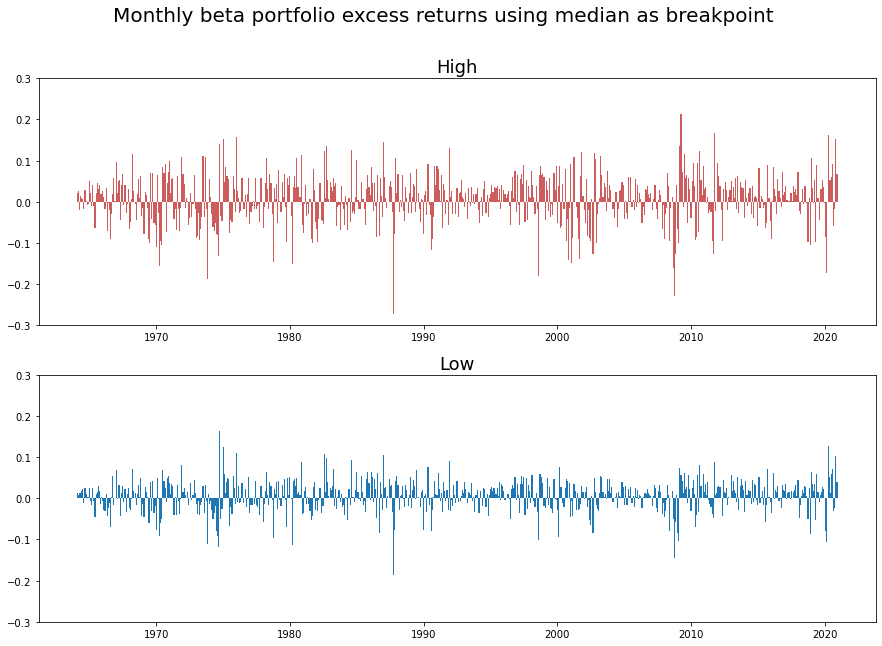

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1,figsize = (15,10))
axs[0].bar(beta_portfolios_wt['monthly_wt_excessret']['high'].index,beta_portfolios_wt['monthly_wt_excessret']['high'],width=30,facecolor='indianred')
axs[1].bar(beta_portfolios_wt['monthly_wt_excessret']['low'].index,beta_portfolios_wt['monthly_wt_excessret']['low'],width=30)
fig.suptitle('Monthly beta portfolio excess returns using median as breakpoint',fontsize=20)
axs[0].set_title('High',fontsize=18)
axs[1].set_title('Low',fontsize=18)
axs[0].set_ylim(-0.3, 0.3)
axs[1].set_ylim(-0.3, 0.3)

We can construct a long-short strategy based on the two portfolios: buy the high-beta portfolio and, at the same time, short the low-beta portfolio. Thereby, the overall position in the market is net-zero, i.e., you do not need to invest money to realize this strategy in the absence of frictions.

In [11]:
beta_longshort=beta_portfolios_wt['monthly_wt_excessret']['high']-beta_portfolios_wt['monthly_wt_excessret']['low']

In [12]:
beta_longshort=beta_longshort.rename('long_short')
beta_longshort=beta_longshort.reset_index()

In [13]:
beta_longshort=pd.merge(beta_longshort,factors_ff_monthly,left_on=["month"],right_on=['month'])

We compute the average return and the corresponding standard error to test whether the long-short portfolio yields on average positive or negative excess returns. In the asset pricing literature, one typically adjust for autocorrelation by using [Newey1987](http://www.jstor.org/stable/1913610) $t$-statistics to test the null hypothesis that average portfolio excess returns are equal to zero. One necessary input for Newey-West standard errors is a chosen bandwidth based on the number of lags employed for the estimation. It seems that researchers often default on choosing a pre-specified lag length of 6 months. This automatic selection is advocated by [Newey1987](http://www.jstor.org/stable/1913610). To implement this test, we compute the average return via `smf.ols()` and then employ the `.fit(cov_type='HAC',cov_kwds={'maxlags':6})` function.

In [14]:
import statsmodels.formula.api as smf
model = smf.ols(formula='long_short ~ 1', data=beta_longshort)
results = model.fit(cov_type='HAC',cov_kwds={'maxlags':6})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                nan
Time:                        12:40:13   Log-Likelihood:                 1378.2
No. Observations:                 683   AIC:                            -2754.
Df Residuals:                     682   BIC:                            -2750.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.907e-06      0.001      0.003      0.9

The results indicate that we cannot reject the null hypothesis of average returns being equal to zero. Our portfolio strategy using the median as a breakpoint hence does not yield any abnormal returns. Is this finding surprising if you reconsider the CAPM? It certainly is. The CAPM yields that the high beta stocks should yield higher expected returns. Our portfolio sort implicitly mimics an investment strategy that finances high beta stocks by shorting low beta stocks. Therefore, one should expect that the average excess returns yield a return that is above the risk-free rate.

## Functional programming for portfolio sorts

Now we take portfolio sorts to the next level. We want to be able to sort stocks into an arbitrary number of portfolios. For this case, functional programming is very handy: we employ the [curly-curly](https://www.tidyverse.org/blog/2019/06/rlang-0-4-0/#a-simpler-interpolation-pattern-with-)-operator to give us flexibility concerning which variable to use for the sorting, denoted by `var`. We use `np.ceil(x.rank()/(len(x)/groups))` to compute breakpoints for `n_portfolios`.

In [15]:
def assign_portfolio(df,var,groups):
    df['portfolio'] = df[var].groupby(df.month).apply(lambda x:np.ceil(x.rank()/(len(x)/groups)))

In [16]:
assign_portfolio(data_for_sorts,'beta_lag',10)

In [17]:
beta_10portfolios_wt=data_for_sorts.groupby(['month', 'portfolio']).apply(lambda x: pd.Series([np.average(x['ret_excess'], weights=x['mktcap_lag'])], 
                                                                index=['monthly_wt_excessret'])).reset_index()

## More performance evaluation

In the next step, we compute summary statistics for each beta portfolio. Namely, we compute CAPM-adjusted alphas, the beta of each beta portfolio, and average returns. 

In [64]:
beta_portfolios_summary=pd.merge(beta_10portfolios_wt,factors_ff_monthly,left_on=['month'],right_on=['month'],how='left')

In [65]:
def getabr(df):
    alpha=smf.ols(formula='monthly_wt_excessret ~ 1 + mkt_excess', data=df).fit().params[0]
    beta=smf.ols(formula='monthly_wt_excessret ~ 1 + mkt_excess', data=df).fit().params[1]
    ret = df.monthly_wt_excessret.mean()
    return alpha,beta,ret

In [66]:
beta_portfolios_summary=beta_portfolios_summary.groupby('portfolio').apply(lambda x :getabr(x) ).rename('abr').reset_index()

In [69]:
beta_portfolios_summary['alpha']=beta_portfolios_summary.abr.apply(pd.Series)[0]
beta_portfolios_summary['beta']=beta_portfolios_summary.abr.apply(pd.Series)[1]
beta_portfolios_summary['ret']=beta_portfolios_summary.abr.apply(pd.Series)[2]
beta_portfolios_summary=beta_portfolios_summary.drop('abr',axis=1)

The figure below illustrates the CAPM alphas of beta-sorted portfolios. It shows that low beta portfolios tend to exhibit positive alphas, while high beta portfolios exhibit negative alphas.

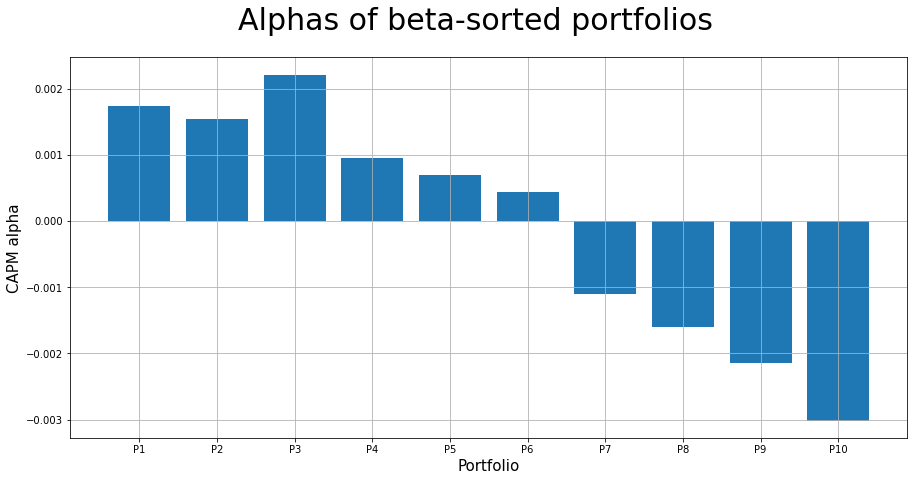

In [96]:
fig, ax = plt.subplots(figsize = (15,7))
ax.bar([ 'P{}'.format(int(n)) for n in beta_portfolios_summary.portfolio ],beta_portfolios_summary.alpha,width=0.8)
fig.suptitle('Alphas of beta-sorted portfolios',fontsize=30)
ax.set_xlabel('Portfolio',fontsize=15)
ax.set_ylabel('CAPM alpha',fontsize=15)
ax.grid()



These results suggest a negative relation between beta and future stock returns, which contradicts the predictions of the CAPM. According to the CAPM, returns should increase with beta across the portfolios and risk-adjusted returns should be statistically indistinguishable from zero.

## The security market line and beta portfolios

The CAPM predicts that our portfolios should lie on the security market line (SML). The slope of the SML is equal to the market risk premium and reflects the risk-return trade-off at any given time.

In [100]:
smf_param=smf.ols(formula='ret ~ 1 + beta', data=beta_portfolios_summary).fit().params

In [160]:
def ablineda(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals ,'-')

d:\Users\81913\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


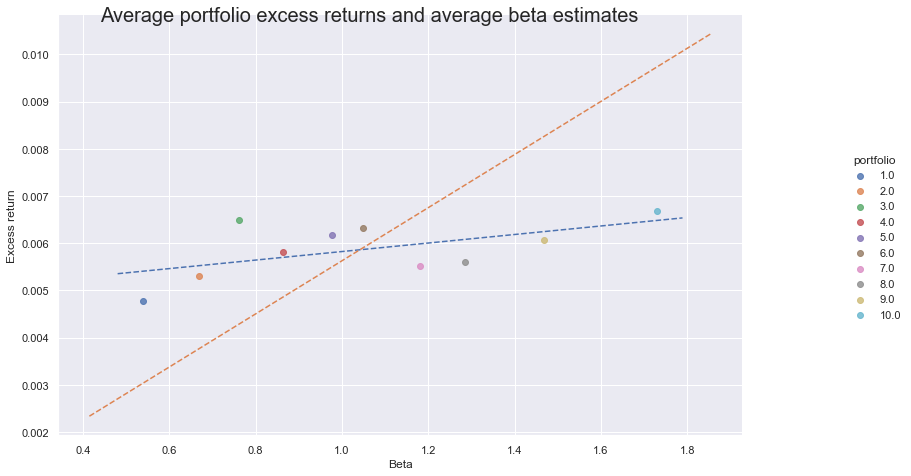

In [161]:
import seaborn as sns
p=sns.lmplot('beta', 'ret', data=beta_portfolios_summary, hue='portfolio', fit_reg=False)
plt.gcf().set_size_inches(15, 7)
p.fig.suptitle('Average portfolio excess returns and average beta estimates',fontsize=20)
p.set( xlabel = "Beta", ylabel = "Excess return")
ablineda(smf_param[1], smf_param[0])
ablineda(factors_ff_monthly.mkt_excess.mean(), 0)
plt.show()

To provide more evidence against the CAPM predictions, we again form a long-short strategy that buys the high-beta portfolio and shorts the low-beta portfolio.

In [266]:
beta_10portfolios=beta_10portfolios_wt.set_index(['month','portfolio']).unstack().reset_index()

In [267]:
beta_10portfolios['long_short']=beta_10portfolios['monthly_wt_excessret',  10.0] - beta_10portfolios['monthly_wt_excessret',  1.0] 
beta_10portfolios['high']=beta_10portfolios['monthly_wt_excessret',  10.0]
beta_10portfolios['low']=beta_10portfolios['monthly_wt_excessret',  1.0] 

In [268]:
beta_10portfolios=beta_10portfolios[['month','long_short','high','low']]

In [269]:
beta_10portfolios.columns=['month','long_short','high','low']

In [270]:
beta_10portfolios=beta_10portfolios.merge(factors_ff_monthly,left_on=['month'],right_on=['month'])

In [271]:
model = smf.ols(formula='long_short ~ 1', data=beta_10portfolios)
results = model.fit(cov_type='HAC',cov_kwds={'maxlags':6})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                nan
Time:                        01:59:04   Log-Likelihood:                 777.12
No. Observations:                 683   AIC:                            -1552.
Df Residuals:                     682   BIC:                            -1548.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0019      0.003      0.603      0.5

In [272]:
model = smf.ols(formula='long_short ~ 1 + mkt_excess', data=beta_10portfolios)
results = model.fit(cov_type='HAC',cov_kwds={'maxlags':6})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     186.9
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           8.90e-38
Time:                        01:59:06   Log-Likelihood:                 995.51
No. Observations:                 683   AIC:                            -1987.
Df Residuals:                     681   BIC:                            -1978.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0048      0.002     -1.949      0.0

The plot below shows the annual returns of the extreme beta portfolios we are mainly interested in. The figure illustrates no consistent striking patterns over the last years - each portfolio exhibits periods with positive and negative annual returns.

In [273]:
beta_10portfolios['year']=beta_10portfolios.month.apply(lambda x:x.year)

In [274]:
beta_10portfolios=beta_10portfolios[['year','long_short','high','low']].set_index('year').stack().rename('ret').reset_index()

In [275]:
beta_10portfolios=beta_10portfolios.rename(columns={'level_1':'portfolio'})

In [289]:
beta_10portfolios_annual=beta_10portfolios.groupby(['year','portfolio']).apply(lambda x:np.prod(x.values+1)).rename('annualret')

In [294]:
beta_10portfolios_annual=(1-beta_10portfolios_annual).unstack().reset_index()

(-1.0, 0.6)

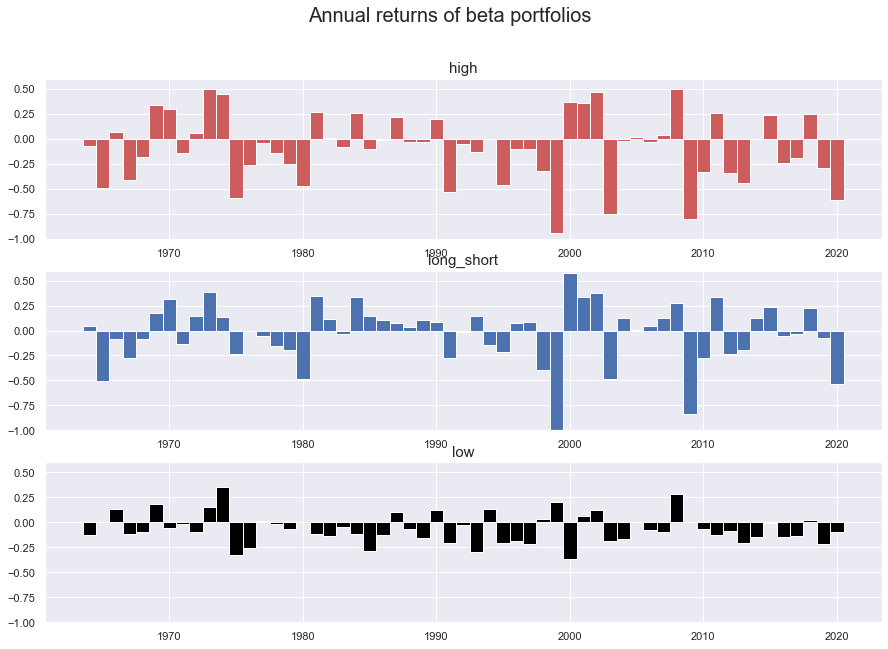

In [299]:
fig, axs = plt.subplots(3,1,figsize = (15,10))
axs[0].bar(beta_10portfolios_annual['year'],beta_10portfolios_annual['high'],width=1,facecolor='indianred')
axs[1].bar(beta_10portfolios_annual['year'],beta_10portfolios_annual['long_short'],width=1)
axs[2].bar(beta_10portfolios_annual['year'],beta_10portfolios_annual['low'],width=1,facecolor='black')
fig.suptitle('Annual returns of beta portfolios',fontsize=20)
axs[0].set_title('high',fontsize=15)
axs[1].set_title('long_short',fontsize=15)
axs[2].set_title('low',fontsize=15)
axs[0].set_ylim(-1, 0.6)
axs[1].set_ylim(-1, 0.6)
axs[2].set_ylim(-1, 0.6)

Overall, this chapter shows how functional programming can be leveraged to form an arbitrary number of portfolios using any sorting variable and how to evaluate the performance of the resulting portfolios. In the next chapter, we dive deeper into the many degrees of freedom that arise in the context of portfolio analysis. 